Deep Hedging in the Black-Scholes market

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.stats import norm
import scipy
import cmath


from scipy.integrate import quad

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

!rm -rf Mean-Variance-Hedging
!git clone https://github.com/chrischia06/Mean-Variance-Hedging

import sys
sys.path.append("Mean-Variance-Hedging/")
from mean_variance_hedge.dynamic_programming import *
from mean_variance_hedge.black_scholes import *
from mean_variance_hedge.utils import *

%load_ext tensorboard

Cloning into 'Mean-Variance-Hedging'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 75 (delta 22), reused 67 (delta 18), pack-reused 0
Unpacking objects: 100% (75/75), done.


Generate Paths

2.763400504619625 0.5138170025230981


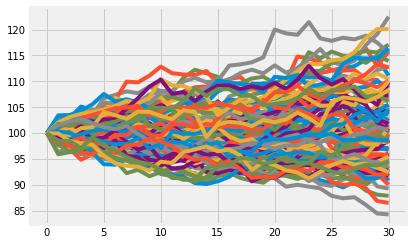

In [ ]:
####################
#    PARAMETERS    #
####################

N_SAMPLES = 10 ** 5 # sample paths to generate

T = 30 # e.g. time, days

sigma =  0.2  # implied volatility , annual
dt = 1 / 250# sampling frequency
S0 = 100.00
r = 0.000 # annual risk-free rate
rf = np.exp(r * dt) # assume no risk-free rate

K_strike = 100.00
CALL = 1

c = 0.5 / 100 # proportional transaction costs



tis, Sts = generate_GBM_paths(n_samples = N_SAMPLES, S0 = S0, T = T, r = r, 
                              sigma = sigma, dt = dt, seed = 2021)

BS_Price = BlackScholes(S0, K_strike, r, sigma, T * dt, 1)
BS_delta = delta(S0, K_strike, r, sigma, T * dt, 1)
print(BS_Price, BS_delta)

# check to make sure values look accurate
plt.plot(Sts[:100,:].T);

Calibrate the log-return space for the quadratic hedging approach

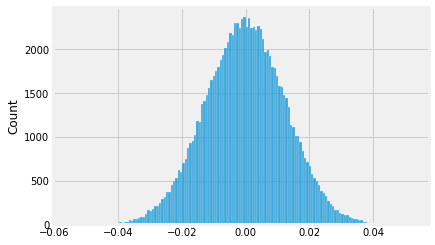

In [ ]:
observed_rets = np.log(Sts[:,1] / Sts[:,0])
fig, ax = plt.subplots()
sns.histplot(observed_rets, ax=ax)

In [ ]:
bounds = np.round([observed_rets.min(), observed_rets.max()], 3)
bins = np.linspace(bounds[0], bounds[1], 8)
counts, val = np.histogram(observed_rets, bins=bins)
p_probs = counts / np.sum(counts)
scale_factor = 10 ** 3
log_ret_space = [round((bins[i] + bins[i + 1]) / 2, 3) for i in range(len(bins) - 1)]
log_ret_space2 = [round(x * scale_factor) for x in log_ret_space]
ret_space = np.exp(log_ret_space) # returns
a, b, m, q_probs = calc_variance_optimal_measure(ret_space, rf, p_probs)
print("Log return space",log_ret_space)

attainable_nodes = possible_nodes(log_ret_space, T, scale_factor)
Hts = calc_mean_value_process(attainable_nodes, S0, K_strike, rf, log_ret_space, T, scale_factor, q_probs)
dynamic_delta = calc_dynamic_deltas(attainable_nodes, Hts, S0, rf, log_ret_space, T, scale_factor, q_probs)    
print("dynamic hedging price",Hts[0][0])

Log return space [-0.047, -0.032, -0.017, -0.001, 0.014, 0.029, 0.044]
dynamic hedging price 2.9480011428474038


In [ ]:
%%time

# hedges for Black Scholes, Dynamic Programming, Dynamic Programming with adjustment
bs_deltas = np.zeros((N_SAMPLES, T))
local_deltas = np.zeros((N_SAMPLES, T ))
dynamic_deltas = np.zeros((N_SAMPLES, T ))

# portfolio value
bs_vals = np.zeros((N_SAMPLES, T + 1)) 
dynamic_vals = np.zeros((N_SAMPLES, T + 1)) 
local_vals = np.zeros((N_SAMPLES, T + 1))

bs_vals[:,0] = BS_Price
local_vals[:,0] = BS_Price
dynamic_vals[:,0] = BS_Price


# calculate the hedging portfolio value
# in the case of the dynamic programming approach, delta is path-dependent

dynamic_deltas[:, 0] = dynamic_delta[0][0]
local_deltas[:, 0] = dynamic_delta[0][0] + rf * a * (Hts[0][0] - local_vals[0,0]) / S0

attainable_rets = {t:np.array(list(attainable_nodes[t])) for t in range(T + 1)}


for i in range(N_SAMPLES):
  for t in range(1, T):
    # calculate closest log-return in the lattice
    current_node = attainable_rets[t][np.abs(attainable_rets[t] - (np.log(Sts[i,t] / S0) * scale_factor)).argmin()]

    local_vals[i, t] = (rf * local_vals[i, t - 1] + 
                        local_deltas[i, t - 1] * (Sts[i, t] - rf * Sts[i, t - 1]))
    
    dynamic_deltas[i, t] = dynamic_delta[t][current_node]
    local_deltas[i, t] = (dynamic_deltas[i, t] +  rf * a * (Hts[t][current_node] - local_vals[i, t]) / Sts[i, t])
    
  local_vals[i, T] = (rf * local_vals[i, T - 1] + 
                      local_deltas[i, T - 1] *  (Sts[i, T] - rf * Sts[i, T - 1]))
  


# Since the Dynamic Delta and Black-Scholes delta depend only on current state St
# they can be quickly computed via vectorisation
for i in range(N_SAMPLES):
  bs_deltas[i, :] = delta(Sts[i, :-1], K_strike, r, sigma, (T - tis[i,:-1]) * dt, CALL) # BS deltas

for t in range(1, T + 1):
  bs_vals[:, t] = (rf * bs_vals[:, t - 1] + 
                     bs_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]))
  dynamic_vals[:, t] = (rf * dynamic_vals[:, t - 1] + 
                      dynamic_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]))

bs_terminal_error = bs_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  
dynamic_terminal_error = dynamic_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)
local_terminal_error = local_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)

CPU times: user 48.5 s, sys: 57.6 ms, total: 48.6 s
Wall time: 48.8 s


Create inputs for Deep Hedger

+ Train on 5000 aditionally generated sample paths, 5000 < 10000
+ Use only Moneyness log(S_{t}/ K) as input

In [ ]:
from sklearn.model_selection import train_test_split
X_true = np.log(Sts[:,:-1] / K_strike)
X_true = X_true.reshape((-1, T, 1))
y_true = Sts.reshape((-1, T + 1, 1))

N_TRAIN_PATHS = 10 ** 5
tis2, train_paths = generate_GBM_paths(n_samples = N_TRAIN_PATHS, S0 = S0, T = T, 
                                       r = r, sigma = sigma, dt = dt, seed = 42)
X = np.log(train_paths / K_strike)

n_feats = 1
X2 = X[:, :-1].reshape((-1, T, n_feats))
y2 = train_paths.reshape((-1, T + 1, n_feats))

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def deep_hedger(T, n_feats):
    """
    Feed-Forward Neural Network
    """
    input_layer = Input(shape = (None, n_feats))
    # batch_norm = BatchNormalization()(input_layer)
    layer_1 = GRU(64, activation='tanh', 
                      kernel_initializer=initializers.RandomNormal(0,0.1),
                      bias_initializer=initializers.RandomNormal(0,0.1),
                  return_sequences=True
                  )(input_layer)
    # layer_2 = Dense(16, activation='relu',
    #                 kernel_initializer=initializers.RandomNormal())(batch_norm1)
    # batch_norm2 = BatchNormalization()(layer_2)
    # layer_3 = Dense(8, activation='relu', 
    #                 kernel_initializer = initializers.RandomNormal())(batch_norm2)
    # batch_norm3 = BatchNormalization()(layer_3)
    output_layer = Dense(1, activation='linear',
                         kernel_initializer=initializers.RandomNormal(),
                         bias_initializer=initializers.RandomNormal(0,0.1)
                         )(layer_1)
    model = Model(input_layer, output_layer)
    return model



In [ ]:
def MSHE_Loss(init_price, strike, T):
    def lossFunction(y_true,y_pred):
      # for simplcity ignore rf and also transaction costs for now, although this could be incorporated
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1) # St - S_{t - 1} increments
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1) # terminal portfolio value
      option_val = tf.math.maximum(y_true[:,-1] - strike, 0) # ZT
      return tf.math.reduce_mean(tf.math.square(-option_val + val + init_price))
    return lossFunction

def cvarLoss(init_price, strike, T, batch_size, proportion = 0.01):
    num = int(batch_size * proportion)
    def lossFunction(y_true,y_pred):
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)      
      option_val = tf.math.maximum(y_true[:,-1,:] - strike, 0)
      # top k worse - net value
      error = tf.reshape(-(-option_val + val + init_price), [-1])
      CVaR, idx = tf.math.top_k(error, tf.constant(num, dtype=tf.int32))
      # return tf.math.reduce_mean(CVaR)
      return tf.math.reduce_mean(CVaR)
    return lossFunction

In [ ]:
# verify functions work
temp_func = cvarLoss(init_price = BS_Price, strike = K_strike, T = T, batch_size = N_SAMPLES, proportion = 0.01)
print(temp_func(y_true, bs_deltas.reshape(-1, T, 1)))
print(temp_func(y_true, dynamic_deltas.reshape(-1, T, 1)))

tf.Tensor(1.47980443690136, shape=(), dtype=float64)
tf.Tensor(1.3927448478715185, shape=(), dtype=float64)


In [ ]:
import os
import datetime
import tensorflow as tf
tf.random.set_seed(2021) # set random seed for reproducibility

######################
### DNN PARAMETERS ###
######################

lr = 0.005
BATCH_SIZE = 256
EPOCHS = 50

# logging and early stopping
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


# Model trained on MSHE
model = deep_hedger(T, n_feats)
model.summary()
print("Check Model", model.predict(np.zeros((1, T, 1))).reshape(-1))

mshe_loss = MSHE_Loss(init_price=BS_Price, strike=K_strike, T = T)
model.compile(optimizer=Adam(learning_rate=lr), loss=mshe_loss)
model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
          batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
          validation_data=(X_val, y_val), shuffle=False)

# # Model trained on CVaR
# cvar_loss = cvarLoss(init_price = BS_Price, strike = K_strike, T = T, batch_size = BATCH_SIZE, proportion = 0.01)

# cvar_model = deep_hedger(T, n_feats)
# cvar_model.compile(optimizer=Adam(learning_rate=lr), loss=cvar_loss)
# cvar_model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
#           batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
#           validation_data=(X_val, y_val), shuffle=False)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Check Model [-0.06002112 -0.06295123 -0.06532431 -0.06741942 -0.06917582 -0.07055762
 -0.07159068 -0.07233414 -0.07285407 -0.0732097  -0.07344861 -0.07360668
 -0.07370988 -0.07377638 -0.07381875 -0.07384543 -0.07386204 -0.07387224
 -0.07387842 -0.07388212 -0.0738843  -0.07388556 -0.07388628 -0.07388668
 -0.0738869  -0.073887   -0.07388704 -0.07388707 -0.07388708 -0.07388708]
Epoch 1

In [ ]:
%%time
## omit the model trained on CVaR

deep_hedge_deltas = np.zeros((N_SAMPLES, T))
# deep_cvar_hedge_deltas = np.zeros((N_SAMPLES, T))

for i in range(T):
  temp= model.predict(X_true[:,:(i + 1),:], batch_size=512)
  deep_hedge_deltas[:,i] =  temp.reshape(-1, i + 1)[:,i]
  # temp2 = cvar_model.predict(X_true[:,:(i + 1),:], batch_size=512)
  # deep_cvar_hedge_deltas[:, i] = temp2.reshape(-1, i + 1)[:,i]

CPU times: user 2min 32s, sys: 9.08 s, total: 2min 41s
Wall time: 1min 39s


In [ ]:
deep_vals = np.zeros((N_SAMPLES, T + 1))
deep_terminal_error = np.zeros(N_SAMPLES)
deep_vals[:,0] = BS_Price

# deep_cvar_vals = np.zeros((N_SAMPLES, T + 1))
# deep_cvar_terminal_error = np.zeros(N_SAMPLES)
# deep_cvar_vals[:,0] = BS_Price


for t in range(1, T + 1):
    deep_vals[:,  t] = rf * deep_vals[:, t - 1] + deep_hedge_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]) 
    # deep_cvar_vals[:, t] = rf * deep_cvar_vals[:, t - 1] + deep_cvar_hedge_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]) 
    

deep_terminal_error = deep_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)
# deep_cvar_terminal_error = deep_cvar_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)

,MSHE,CVar 1%,CVaR 5%,CVar 10%,CVaR 50%
BS-delta,0.187350,1.479804,1.012283,0.810759,0.327311
Local Hedge,0.198975,1.399998,0.973319,0.790484,0.342440
Dynamic Hedge,0.197068,1.392745,0.967702,0.785861,0.340879
Deep-Hedger,0.207814,1.470625,1.017170,0.823506,0.344510


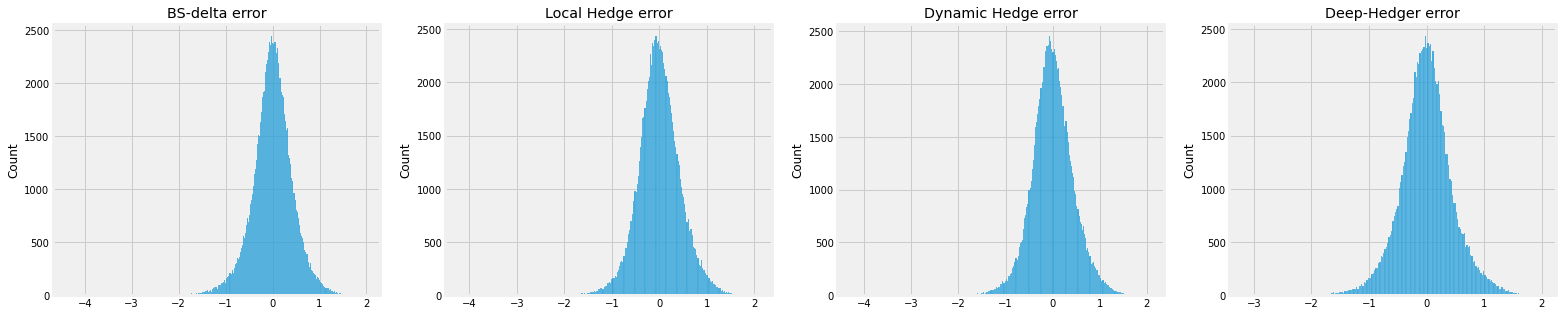

In [ ]:
## Plot VT - ZT distribution, and MSHE and CVaR levels
hedging_errors = [bs_terminal_error, local_terminal_error, dynamic_terminal_error,
                  deep_terminal_error] #, deep_cvar_terminal_error]

hedging_errors2 = [diagnosis(error) for error in hedging_errors]
results = pd.concat(hedging_errors2)

titles = ["BS-delta", "Local Hedge", "Dynamic Hedge", ] + ["Deep-Hedger"]#, "Deep-CVaR-Hedger"]
results.index = titles
display(results)


plot_titles = [title +" error" for title in titles]
fig, ax = plt.subplots(ncols= len(titles), figsize=(len(titles) * 6, 5))
for i in range(len(titles)):
  sns.histplot(hedging_errors[i], ax=ax[i]).set_title(plot_titles[i]) 

In [ ]:
print(results.to_latex()) #print table to LaTeX

\begin{tabular}{lrrrrr}
\toprule
{} &      MSHE &   CVar 1\% &   CVaR 5\% &  CVar 10\% &  CVaR 50\% \\
\midrule
BS-delta      &  0.187350 &  1.479804 &  1.012283 &  0.810759 &  0.327311 \\
Local Hedge   &  0.198975 &  1.399998 &  0.973319 &  0.790484 &  0.342440 \\
Dynamic Hedge &  0.197068 &  1.392745 &  0.967702 &  0.785861 &  0.340879 \\
Deep-Hedger   &  0.207814 &  1.470625 &  1.017170 &  0.823506 &  0.344510 \\
\bottomrule
\end{tabular}

